# Experiment and path specification

In [1]:
# Specify the experiment for analysis
experiment='cxix40218'
runNumber = 50
experiment='cxilu9218'
runNumber = 14

# Set the installation and output path
import os
os.environ['INSTALLPATH']= '/cds/home/m/mrware/TRXS-dev/TRXS-Run18'
os.environ['OUTPUTPATH']= '/cds/data/psdm/%s/%s/scratch' % (experiment[0:3],experiment)

# Import Libraries

In [2]:
# Magic iPython command to enable plotting
%matplotlib inline

# Load in the pythonBatchMagic library
import sys
print os.environ['INSTALLPATH']+'/Libraries/pythonBatchMagic'
sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/pythonBatchMagic')
from pythonBatchMagic import *
# Determine current user
currentUser, error = unixCMD("echo $USER")
print(currentUser)
os.environ['RESULTSPATH']= ('/cds/data/psdm/%s/%s/results/%s' % (experiment[0:3],experiment,currentUser)).strip()
if not os.path.exists(os.environ['RESULTSPATH']):
    os.mkdir(os.environ['RESULTSPATH'])

/cds/home/m/mrware/TRXS-dev/TRXS-Run18/Libraries/pythonBatchMagic
Current user is mrware will output batch to /cds/data/psdm/cxi/cxilu9218/scratch/mrware/Batch
mrware



# Leveraging the batch queue to quickly grab detector data

## Loading libraries

In [3]:
sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/LCLS')
from LCLSdefault import *

sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/mattsLibraries')
from picklez import *

# Load in the get data library
from dataAnalysis import *

# Load in the batch library for lcls
from lclsBatch import *

IOError: Did you load the correct file? /cds/data/psdm/cxi/cxilu9218/scratch/Memories/getCSPADcoords
Current user is mrware will output batch to /cds/data/psdm/cxi/cxilu9218/scratch/mrware/Batch


## Load point data

In [4]:
pointData = load_obj( os.environ['RESULTSPATH']+'/pointData-run-%d' % runNumber )

/cds/data/psdm/cxi/cxilu9218/results/mrware/pointData-run-14 remembered!


## Plot histogram of result

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

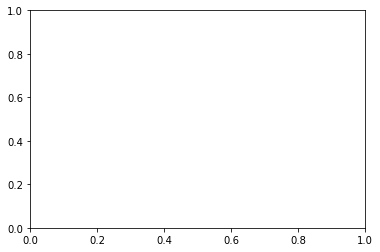

In [7]:
detArrays = pointData

fig2, ax2 = plt.subplots(1, 1)
ax2.hist(detArrays['uvint1'], bins=100,normed=False, alpha=0.5);

# Read in CSPAD via batch job

## Specify good idxs

In [8]:
goodIdx = runFilter( pointData , filterOn=['xrayEnergy', 'ttfltpos'], maddevs=3 ).astype(bool)
print 'Number of good shots: ', len(goodIdx[goodIdx==True])

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

## Now generate time delays

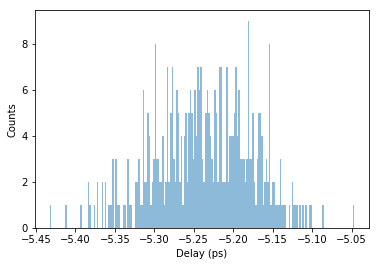

In [8]:
TTPoly = np.array([2.235e-7, -2.21e-3, 8.547e-1]) # ANDY, NOLAN, etc UPDATE ME

TTFltPos = pointData['ttfltpos']
TTCorrFltPos = TTPoly[0]*TTFltPos**2+TTPoly[1]*TTFltPos+TTPoly[2]
TTTime = TTCorrFltPos - 1e9/3e8*2*(pointData['stageencoder']-56.35)

# NOTE: This is a placeholder, and should be removed on runs with timetool data
# TTTime = np.zeros(pointData['xrayEnergy'].shape)

fig2, ax2 = plt.subplots(1, 1)
ax2.hist(TTTime[goodIdx], bins=200,normed=False, alpha=0.5)
ax2.set_xlabel('Delay (ps)')
ax2.set_ylabel('Counts')
plt.show()

# Read in all images

In [16]:
tagList = []
# NTOT = detArrays['uvint'][goodIdx].size
NTOT = 10e2
NGRAB = 10
NCORE = int( float(NTOT)/float(NGRAB) )

print('Grabbing %d shots, %d events at a time, on %d nodes' %(NTOT,NGRAB,NCORE))

for idx in range(NCORE):
    filteredSeconds = pointData['seconds'][goodIdx][0+NGRAB*idx:NGRAB+NGRAB*idx]
    filteredNanoseconds = pointData['nanoseconds'][goodIdx][0+NGRAB*idx:NGRAB+NGRAB*idx]
    filteredFiducials = pointData['fiducials'][goodIdx][0+NGRAB*idx:NGRAB+NGRAB*idx]
    tagList.append( {'seconds':filteredSeconds, 'nanoseconds':filteredNanoseconds, 'fiducials':filteredFiducials} )

# batchThreads = batchCSPADGrabber (tagList, experiment=experiment, runNumber=runNumber)
batchThreads = batchCSPADMVGrabber (tagList, experiment=experiment, runNumber=runNumber, detType='Jungfrau')
timebins=np.arange(NCORE)
# batchThreads.Queue = 'psanaq'   
batchThreads.Queue = 'psfehhiprioq'
batchThreads.start()

Grabbing 1000 shots, 10 events at a time, on 100 nodes
Deleting the old output file ...
Output: 
Error: None
Deleting the old executable file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=7000]" -q psfehhiprioq -o /cds/data/psdm/cxi/cxix40218/scratch/mrware/Batch/Output/CSPADMV-run-50-temp-CSPAD-0.out /cds/home/m/mrware/TRXS-dev/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh python2 /cds/data/psdm/cxi/cxix40218/scratch/mrware/Batch/Python/CSPADMV-run-50-temp-CSPAD-0.py; exit'
Deleting the old output file ...
Output: 
Error: None
Deleting the old executable file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=7000]" -q psfehhiprioq -o /cds/data/psdm/cxi/cxix40218/scratch/mrware/Batch/Output/CSPADMV-run-50-temp-CSPAD-1.out /cds/home/m/mrware/TRXS-dev/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh python2 /cds/data/psdm/cxi/cxix40218/scratch/mrware/Batch/Python/CSPADMV-run-50-temp-CSPAD-1.py; exit'
Output: Job <220140> is s

# Read in timebinned CSPAD
## If you want to timebin your images

In [9]:
# timebins = np.arange( -1.5,1.5,.03 )
# timebins are in picoseconds
# timebins = np.arange( 2.,5.5,.03 ) 
timebins = np.arange( -5.5, 5.5, .2 )
print 'Number of timebins: ', len(timebins)
dt = timebins[1]-timebins[0]
NT = timebins.size

tagList = []
for idx, t in enumerate(timebins):
    tIndex = (TTTime >= t-dt/2.)&(TTTime < t+dt/2.)
    allIndex = tIndex & goodIdx
    filteredSeconds = pointData['seconds'][allIndex]
    filteredNanoseconds = pointData['nanoseconds'][allIndex]
    filteredFiducials = pointData['fiducials'][allIndex]
    tagList.append( {'seconds':filteredSeconds, 'nanoseconds':filteredNanoseconds, 'fiducials':filteredFiducials} )

# batchThreads = batchCSPADGrabber (tagList, experiment=experiment, runNumber=runNumber, detType='Jungfrau')
batchThreads = batchCSPADMVGrabber (tagList, experiment=experiment, runNumber=runNumber, detType='Jungfrau')

batchThreads.Queue = 'psfehhiprioq'
batchThreads.RunType = 'python2'
batchThreads.start()


Number of timebins:  55
Deleting the old output file ...
Output: 
Error: None
Deleting the old executable file ...


## Check job status

In [20]:
print batchThreads.status
stdoutdata, stderrdata = bjobs()
print stdoutdata
print stderrdata

Stopped
JOBID   USER    STAT  QUEUE      FROM_HOST   EXEC_HOST   JOB_NAME   SUBMIT_TIME
220896  mrware  RUN   psfehhipri psanagpu101 psana1601   *PAD-38.py Nov 27 09:23




## Kill threads if they die

In [21]:
batchThreads.requestStop()
time.sleep(5)
stdoutdata, stderrdata = bkill(killAll=True)
print stdoutdata
print stderrdata


No unfinished job found



# Save resulting CSPAD

In [13]:
batchThreads.gather()
CSPAD = batchThreads.CSPAD
variance = batchThreads.variance
counts = batchThreads.counts

IOError: Did you load the correct file? /cds/data/psdm/cxi/cxix40218/scratch/mrware/Batch/Output/mean-var-node-0-run-50
[Errno 2] No such file or directory: '/cds/data/psdm/cxi/cxix40218/scratch/mrware/Batch/Output/mean-var-node-0-run-50.pkl'
IOError: Did you load the correct file? /cds/data/psdm/cxi/cxix40218/scratch/mrware/Batch/Output/mean-var-node-1-run-50
[Errno 2] No such file or directory: '/cds/data/psdm/cxi/cxix40218/scratch/mrware/Batch/Output/mean-var-node-1-run-50.pkl'
IOError: Did you load the correct file? /cds/data/psdm/cxi/cxix40218/scratch/mrware/Batch/Output/mean-var-node-2-run-50
[Errno 2] No such file or directory: '/cds/data/psdm/cxi/cxix40218/scratch/mrware/Batch/Output/mean-var-node-2-run-50.pkl'
/cds/data/psdm/cxi/cxix40218/scratch/mrware/Batch/Output/mean-var-node-3-run-50 remembered!
/cds/data/psdm/cxi/cxix40218/scratch/mrware/Batch/Output/mean-var-node-4-run-50 remembered!
/cds/data/psdm/cxi/cxix40218/scratch/mrware/Batch/Output/mean-var-node-5-run-50 remembe

In [14]:
from scipy.io import savemat
np.save(os.environ['RESULTSPATH']+'/timebins-run-%d' % runNumber ,timebins)
np.save(os.environ['RESULTSPATH']+'/CSPAD-run-%d' % runNumber  , CSPAD)
np.save(os.environ['RESULTSPATH']+'/variance-run-%d' %  runNumber , variance)
np.save(os.environ['RESULTSPATH']+'/counts-run-%d' % runNumber  , counts)

filename = os.environ['RESULTSPATH']+'/timebinned-detector-images-run-%d' % runNumber
mdict = {'timebins':timebins,'CSPAD':CSPAD,'variance':variance,'counts':counts}
savemat(filename, mdict)

# Plot CSPAD

In [ ]:
# # Optional code if timebinned frames are already saved
timebins = np.load(os.environ['RESULTSPATH']+'/timebins-run-%d.npy' % runNumber )
CSPAD = np.load(os.environ['RESULTSPATH']+'/CSPAD-run-%d.npy' % runNumber)
variance = np.load(os.environ['RESULTSPATH']+'/variance-run-%d.npy' % runNumber)
counts = np.load(os.environ['RESULTSPATH']+'/counts-run-%d.npy' % runNumber)

In [ ]:
for i in range(CSPAD.shape[-1]):
    m = np.mean(CSPAD[:,:,:,i])
    if not np.isnan(m):
        print i, np.mean(CSPAD[:,:,:,i]), counts[i][0], timebins[i]

(0.0, 2.2)


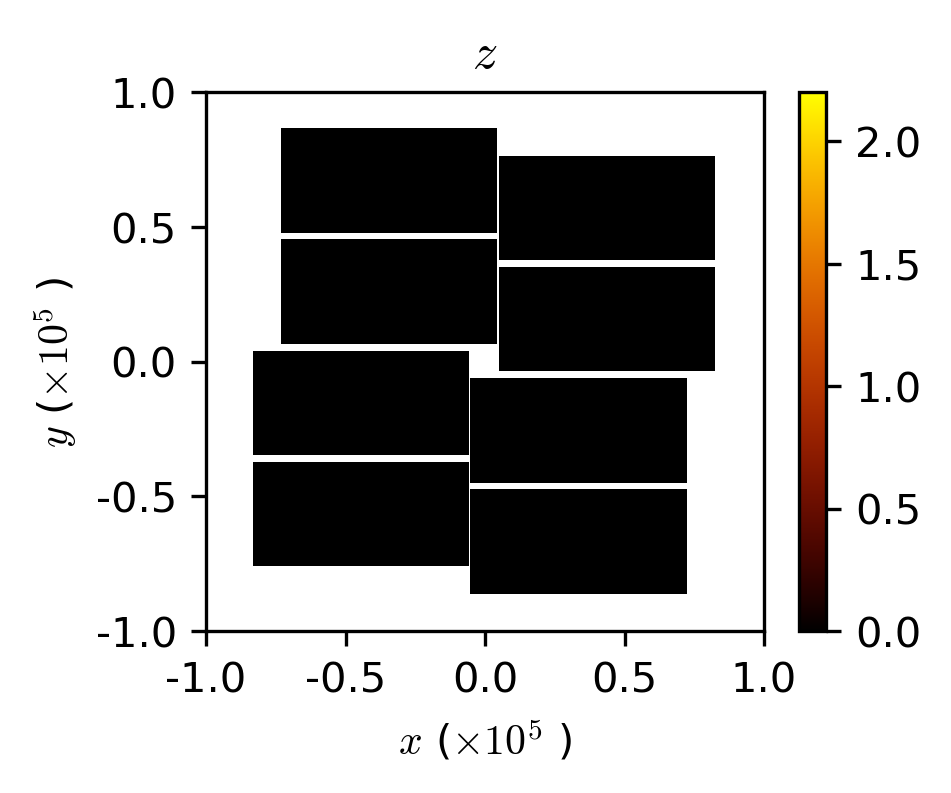

In [15]:
from IPython.display import clear_output
from plotStyles import *

def plotCSPAD( cspad , x , y, cspadMask=None, zLims = None, divergent=False, NTILE=8 ):
    figOpts = {'xLims':[-1e5,1e5],'yLims':[-1e5,1e5],'divergent':divergent, 'xIn':3, 'yIn':3*11.5/14.5}
    
    if zLims is not None:
        figOpts['zLims'] = zLims
    
    for iTile in range(NTILE):
    
        if cspadMask is not None:
            cspadTile = cspad[iTile,:,:]
            tileMask = ~cspadMask[iTile,:,:]
            cspadTile[tileMask] = 0
        
        if iTile == 0:
            newFigure = True
        else:
            newFigure = False
            
        clear_output()
        colorPlot( x[iTile,:,:], y[iTile,:,:], cspadTile , newFigure=newFigure, **figOpts);


x,y = CSPADgeometry(detType='Jungfrau', run=runNumber, experiment=experiment)
# cspadMask = createMask(experiment=experiment, run=runNumber, detType='Jungfrau').astype(bool)
cspadMask = np.ones_like(x).astype(bool)
print(cspadMask.shape)

print CSPAD.shape
CSPADbinned = CSPAD

# CSPADbinned[CSPADbinned>10]=0
CSPAD2plot = np.nansum(CSPADbinned[:,:,:,:],axis=-1)#-CSPADbinned[:,:,:,53]
# plotCSPAD( cspadMask, x , y , cspadMask=cspadMask, divergent=True )
# plotCSPAD( np.sum(CSPADbinned[:,:,:,:100], axis=-1)-np.sum(CSPADbinned[:,:,:,100:200], axis=-1), x , y , cspadMask=cspadMask, divergent=False, NTILE=8 )
plotCSPAD( CSPAD2plot, x , y , zLims=[0,2],
          cspadMask=cspadMask, divergent=False, NTILE=8 )
